# Seidel Fitting

<a target="_blank" href="https://colab.research.google.com/github/chromatix-team/chromatix/blob/main/docs/examples/seidel_fitting.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In this notebook we will fit Seidel coefficients to measured point spread functions. The primary Seidel coefficients are a set of 5 numbers that correspond to common aberrations: Sphere, Coma, Astigmatism, Field Curvature, Distortion.

In [ ]:
# If in Colab, install Chromatix. Don't forget to select a GPU!
!pip install --upgrade pip
!pip install git+https://github.com/chromatix-team/chromatix.git

In [5]:
from typing import Callable, Optional, Tuple

import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from flax.training.train_state import TrainState
from jax import random

from chromatix.elements import (
    FFLens,
    ObjectivePointSource,
    SeidelAberrations,
    trainable,
)
from chromatix.ops import shot_noise

key = random.PRNGKey(42)

2024-05-23 21:54:53.309082: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Before we construct our seidel fitter, let's define some simulation parameters based on desired camera specifications.

In [6]:
camera_shape: Tuple[int, int] = (256, 256)
camera_pixel_pitch: float = 0.125
f: float = 100
NA: float = 0.8
n: float = 1.33
wavelength: float = 0.532
wavelength_ratio: float = 1.0
upsample: int = 4
pad: int = 128
crop: int = 450 # for visualization purposes
taper_width: Optional[float] = 5
noise_fn: Callable = shot_noise
shape = tuple(np.array(camera_shape) * upsample + pad)
spacing = upsample* f * wavelength/ (n * shape[0] * camera_pixel_pitch)

print(f"Shape of simulation: {shape}")
print(f"Spacing of simulation: {spacing:.2f}")

Shape of simulation: (1152, 1152)
Spacing of simulation: 1.11


## Constructing the forward model 

First we need to model how Seidel coefficients are transformed into PSFs. This is done by plugging in the coefficients into the Seidel polynomial, which yields a 2D phase distribution. This distribution is then used as the phaseof the pupil function, and finally, the Fourier Transform of the pupil function is the PSF.

We implement the model by using an FFLens to Fourier transform the pupil function specified by SeidelAberrations. 

*Note: In general, Seidel aberrations are shift-varying, so we need to specify a location in object space (u,v).*

In [7]:
class SeidelPSF(nn.Module):
    @nn.compact
    def __call__(self, z, u, v):
        field  = ObjectivePointSource(shape, spacing, wavelength, wavelength_ratio, f, n, NA, power=1e3)(z)
        # The only learnable parameters are the seidel coefficients (since we use the trainable flag) 
        field = SeidelAberrations(trainable(jnp.array([0.,0.,0.,0.,0.])), f, n, NA, u, v)(field) #init all coeffs to 0
        field = FFLens(f, n)(field)
        return field    

Now, using the SeidelPSF forward model, let's generate a "measured" PSF for some "unknown" coefficients that we will ultimately like to learn. For now, we will pick a PSF at the very bottom of the field-of-view with significant Sphere, Coma, and Astigmatism.

{'state': {'ObjectivePointSource_0': {'_f': 100, '_n': 1.33, '_NA': 0.8, '_power': 1000.0, '_amplitude': 1.0}, 'FFLens_0': {'_f': 100, '_n': 1.33, '_NA': None}}, 'params': {'SeidelAberrations_0': {'_coefficients': Array([0., 0., 0., 0., 0.], dtype=float32)}}}


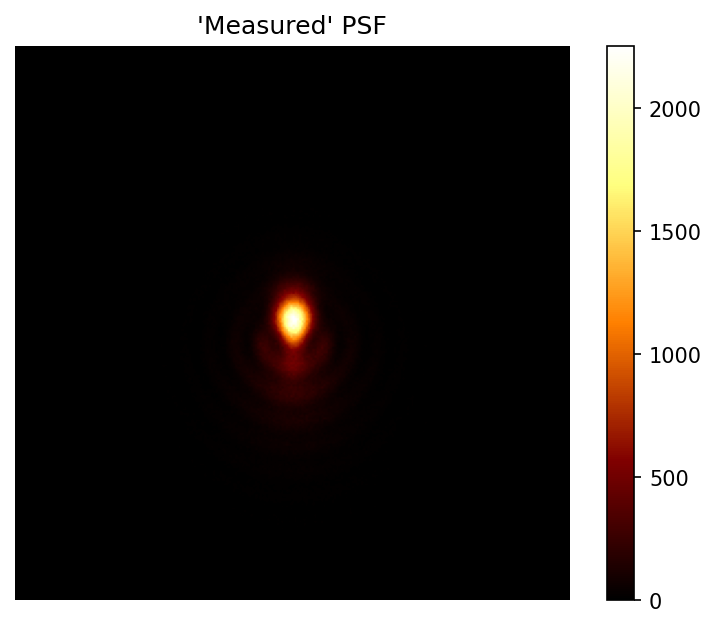

In [8]:
# init model
model = SeidelPSF()
variables = model.init(key, z=0, u=0, v=0) # dummy parameters for init
print(variables)

# Split into two
params, state = variables["params"], variables["state"]
del variables # delete for memory

# specify the "ground truth" coefficients (which will eventually try to estimate)
coefficients_truth = jnp.array([5.,5.,5.,0,0])
params_truth = {'SeidelAberrations_0': {'_coefficients': coefficients_truth}}

# get the corresponding "measured" PSF using the true coefficients
psf_truth = model.apply({"params": params_truth, "state": state}, z=0, u=0, v=1) # v=1 means this PSF will be near the bottom of the FoV
psf_truth = shot_noise(key, psf_truth.intensity) # add some noise because it is measured!

plt.figure(dpi=150)
plt.imshow(psf_truth.squeeze()[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar()
plt.title("'Measured' PSF")
plt.axis("off")
plt.show()

## Learning Seidel Coefficients 

Now that we have our target PSF, we will learn its underlying Seidel coefficients by optimizing through the forward model. First let's define a few functions needed for the training.

In [9]:
# This loss function will be our metric for measuring how close our predicted PSF is to the measured PSF. For now we
# use mean squared error.
def loss_fn(params, state, data, z, u, v):
    psf_estimate = model.apply({"params": params, "state": state}, z=z, u=u, v=v).intensity
    loss = jnp.mean(jnp.square(psf_estimate - data))
    return loss, {"loss": loss}

# Setting the state which has the model, params and optimiser
trainstate = TrainState.create(apply_fn=model.apply, 
                          params=params, 
                          tx=optax.adam(learning_rate=0.5))

# Defining the function which returns the gradients
grad_fn = jax.jit(jax.grad(loss_fn, has_aux=True))

Now its time to learn! We using our forward model and the optimization parameters/functions specified above we will
learn the coefficients that correspond to a PSF that best matches our measured PSF. First we display our initial guess.

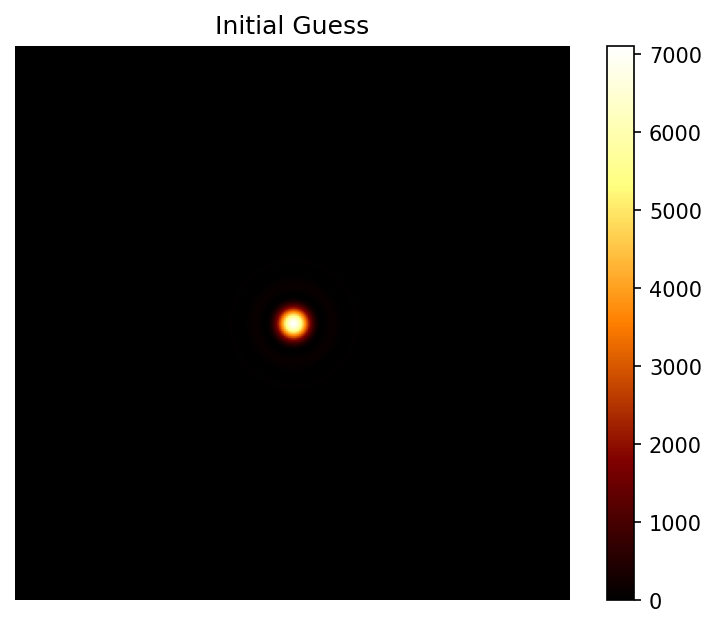

In [10]:
psf_init = model.apply({"params": params, "state": state}, z=0, u=0, v=1).intensity.squeeze()

plt.figure(dpi=150)
plt.imshow(psf_init.squeeze()[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar()
plt.title("Initial Guess")
plt.axis("off")
plt.show()

Below is the optimization loop:

In [11]:
%%time
# Now we optimize
max_iterations = 1000
print_every = 100
history = []
for iteration in range(max_iterations):
    grads, metrics = grad_fn(trainstate.params, state, psf_truth, z=0.0, u=0.0, v=1.0) 
    trainstate = trainstate.apply_gradients(grads=grads)
    history.append(metrics["loss"])
    if iteration % print_every == 0:
        print(iteration, metrics)

0 {'loss': Array(1069.5322, dtype=float32)}
100 {'loss': Array(1.503792, dtype=float32)}
200 {'loss': Array(1.1014638, dtype=float32)}
300 {'loss': Array(0.89027464, dtype=float32)}
400 {'loss': Array(0.80913234, dtype=float32)}
500 {'loss': Array(0.7849123, dtype=float32)}
600 {'loss': Array(0.77915186, dtype=float32)}
700 {'loss': Array(0.7780531, dtype=float32)}
800 {'loss': Array(0.7778858, dtype=float32)}
900 {'loss': Array(0.777865, dtype=float32)}
CPU times: user 4.54 s, sys: 1.57 s, total: 6.12 s
Wall time: 5.58 s


Let's see how well we did!

In [12]:
# Our final predicted coefficients
coefficients_estimated = jnp.abs(trainstate.params['SeidelAberrations_0']['_coefficients'])
print('Estimated coefficients:', coefficients_estimated)

coefficients_error = jnp.mean(jnp.square(coefficients_estimated - coefficients_truth))
print('Coefficients error:', coefficients_error)

Estimated coefficients: [4.9830189e+00 4.9887118e+00 4.9946280e+00 1.2477187e-02 3.8094406e-03]
Coefficients error: 0.00012296645


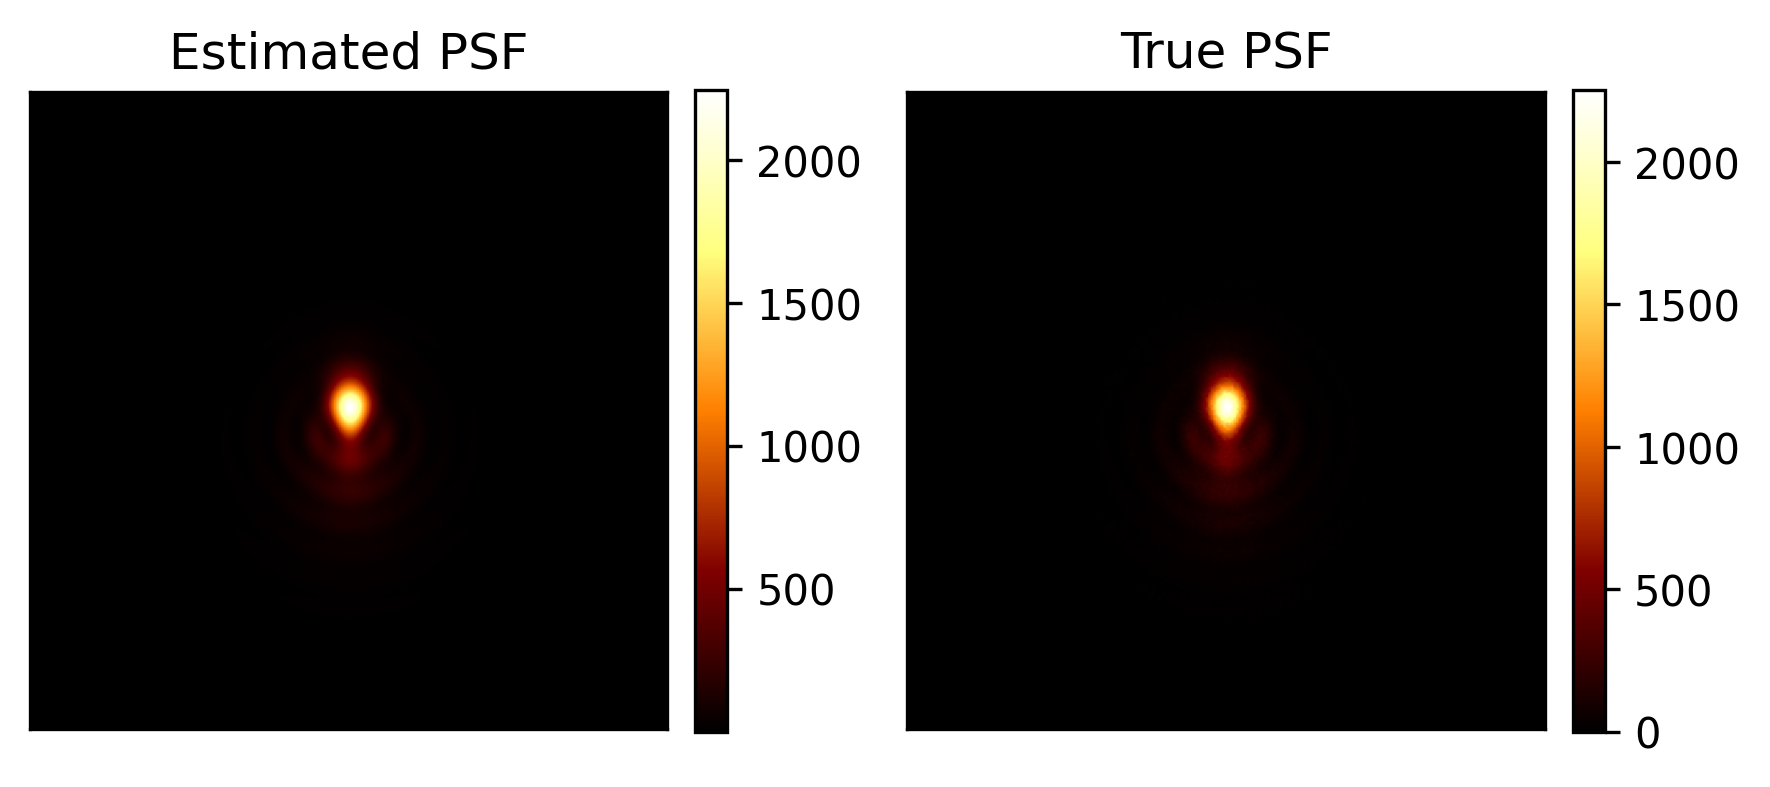

In [9]:
psf_estimated = model.apply({"params": trainstate.params, "state": state}, z=0, u=0, v=1).intensity.squeeze()

fig, ax = plt.subplots(1,2, dpi=300)
m = ax[0].imshow(psf_estimated[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar(m, fraction=0.046, pad=0.04)
ax[0].title.set_text('Estimated PSF')
m = ax[1].imshow(psf_truth.squeeze()[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar(m, fraction=0.046, pad=0.04)
ax[1].title.set_text('True PSF')
for ax in ax:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()